# Score cell cycle

In [1]:
import os,sys
import datetime

### Import scanpy

In [2]:
import scanpy.api as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.3.4 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
Memory usage: current 0.17 GB, difference +0.17 GB


### Import my utility functions and import statements from github

In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190425_11h32"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import
import rz_utility_spring as srz

python version: 3.6.7


## Load data and place into an annData object

In [5]:
!ls data_from_geo

cell_info_8594x25.tsv         injury_barcodes.tsv
control_barcodes.tsv          injury_genes.tsv
control_genes.tsv             injury_loom.loom
control_loom.loom             injury_matrix.mtx
control_matrix.mtx            raw_counts_8594x27998.mtx
gene_names_alphabetically.txt


In [6]:
obspath = 'data_from_geo/cell_info_8594x25.tsv'
countpath = 'data_from_geo/raw_counts_8594x27998.mtx'
genepath = 'data_from_geo/gene_names_alphabetically.txt'

In [7]:
# load cell info
obs = pd.read_csv(obspath,sep='\t',index_col=0)
print(obs.shape)
obs.head()

(8594, 25)


,barcode,condition,total_counts,pass_quality_filters,inj_epithelial,ctr_epithelial,excluded_as_immune_or_mesench,class,population,phase,...,x_control,y_control,x_class3_exploded,y_class3_exploded,x_control_injured,y_control_injured,x_class1_CTR_cell_cyc_removed,y_class1_CTR_cell_cyc_removed,x_class1_INJ_cell_cyc_removed,y_class1_INJ_cell_cyc_removed
0,AAACCTGAGTGCTGCC-1,control,2787,True,False,True,False,class3,ctr_DEEx,G1,...,783.705500,-377.074709,1082.172898,-266.303304,709.78614,-325.505019,NaN,NaN,NaN,NaN
1,AAACCTGAGTGGGTTG-1,control,3325,True,False,True,False,class3,ctr_upper_IEE,G1,...,709.612642,-429.409941,854.230866,-454.025809,529.15516,-471.961493,NaN,NaN,NaN,NaN
2,AAACCTGCAAGTCTAC-1,control,1781,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGCAATCTGCA-1,control,3468,True,False,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGCACGGTGTC-1,control,1745,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# load counts
adata = sc.read_mtx(countpath)
print(adata.shape)

# add genes (annotation of variables)
adata.var['genes'] = np.loadtxt(genepath,dtype=str)

# make sure var names are genes
adata.var_names = adata.var['genes'].values

# add obs (annotation of observations)
adata.obs = obs

# make sure index is unique AND a string
adata.obs_names_make_unique()
adata.obs_names = adata.obs_names.astype(str)

(8594, 27998)


## Download cell cycle gene list

In [14]:
#!mkdir -p Seurat_cell_cycle
# download cell cycles genes from here:
# https://www.dropbox.com/s/3dby3bjsaf5arrw/cell_cycle_vignette_files.zip?dl=1
# place into Seural_cell_cycle, unzip

ccpath = 'Seurat_cell_cycle/cell_cycle_vignette_files/regev_lab_cell_cycle_genes.txt'
cell_cycle_genes = np.loadtxt(ccpath,dtype='str')

print(len(cell_cycle_genes),len(set(cell_cycle_genes)))

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

97 97


### Human-to-mouse gene translation

In [16]:
# whoops, looks like these are human genes, and I have mouse data
# download a mouse-human orthology table fro mgi
# in general, for this purpose I want to be permissive

#opath = "http://www.informatics.jax.org/downloads/reports/HMD_HumanPhenotype.rpt"
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#!mkdir mouse_human_orthologs
#!cd mouse_human_orthologs && curl -LO $opath
#!echo "Downloaded from $opath \n on $toappend" > mouse_human_orthologs/readme.txt

mkdir: mouse_human_orthologs: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1482k  100 1482k    0     0   215k      0  0:00:06  0:00:06 --:--:--  321k


In [17]:
oframe = pd.read_csv('mouse_human_orthologs/HMD_HumanPhenotype.rpt',sep='\t',header=None)

# human to mouse dictionary
h2m = {}
for h,m in zip(oframe[0],oframe[4]):
    if h not in h2m:
        h2m[h] = []
    h2m[h] = h2m[h]+[m]

    
# translate s_genes
# check the length before
print(len(s_genes))

# translate
s_genes = [h2m[i] for i in s_genes if i in h2m]
print(len(s_genes)) # if fewer, some human genes were not in the dictionary

# flatten
s_genes = rz.flatten_list_of_lists(s_genes)
print(len(s_genes))

# make sure no gene names repeated after translation
s_genes = rz.oset(s_genes)
print(len(s_genes))

# same with g2m_genes
g2m_genes = [h2m[i] for i in g2m_genes if i in h2m]
print(len(g2m_genes)) # if fewer, some human genes were not in the dictionary

# flatten
g2m_genes = rz.flatten_list_of_lists(g2m_genes)
print(len(g2m_genes))

# make sure no gene names repeated after translation
g2m_genes = rz.oset(g2m_genes)
print(len(g2m_genes))

# overwrite cell cycle genes
cell_cycle_genes = s_genes + g2m_genes
print(len(cell_cycle_genes))
cell_cycle_genes = rz.oset(cell_cycle_genes)d
print(len(cell_cycle_genes))

43
42
42
42
52
52
52
94
94


### Calculate cell cycle scores

In [18]:
# select cells to consider...
cell_mask = adata.obs['ctr_epithelial'].astype(bool).values
print(cell_mask.sum())

2349


In [19]:
# make a copy of adata only focusing on cells of interest
cdata = adata[cell_mask,:].copy()

# filter out genes with zero counts
min_non_zero = cdata.X.data.min()
sc.pp.filter_genes(cdata,min_counts=min_non_zero)

# scale to 1e4 total counts
sc.pp.normalize_per_cell(cdata, counts_per_cell_after=1e4)

# log transform
sc.pp.log1p(cdata)

# zscore
sc.pp.scale(cdata)

filtered out 11145 genes that are detected in less than 1.0 counts


In [12]:
# make a copy of adata only focusing on cells of interest
cdata = adata[cell_mask,:].copy()

# filter out genes with zero counts
min_non_zero = cdata.X.data.min()
sc.pp.filter_genes(cdata,min_counts=min_non_zero)

# scale to 1e4 total counts
sc.pp.normalize_per_cell(cdata, counts_per_cell_after=1e4)

# log transform
sc.pp.log1p(cdata)

# zscore
sc.pp.scale(cdata)

filtered out 2017 genes that are detected in less than 0.25150827 counts


In [20]:
# make sure to only leave those cell cycle genes I have in the reduced dataset
print(len(s_genes),len(g2m_genes),len(cell_cycle_genes))
s_genes = [i for i in s_genes if i in cdata.var_names]
g2m_genes = [i for i in g2m_genes if i in cdata.var_names]
cell_cycle_genes = [i for i in cell_cycle_genes if i in cdata.var_names]
print(len(s_genes),len(g2m_genes),len(cell_cycle_genes))

42 52 94
42 52 94


In [33]:
help(sc.tl.score_genes)

Help on function score_genes in module scanpy.tools.score_genes:

score_genes(adata, gene_list, ctrl_size=50, gene_pool=None, n_bins=25, score_name='score', random_state=0, copy=False, use_raw=False)
    Score a set of genes [Satija15]_.
    
    The score is the average expression of a set of genes subtracted with the
    average expression of a reference set of genes. The reference set is
    randomly sampled from the `gene_pool` for each binned expression value.
    
    This reproduces the approach in Seurat [Satija15]_ and has been implemented
    for Scanpy by Davide Cittaro.
    
    Parameters
    ----------
    adata : :class:`~anndata.AnnData`
        The annotated data matrix.
    gene_list : iterable
        The list of gene names used for score calculation.
    ctrl_size : `int`, optional (default: 50)
        Number of reference genes to be sampled. If `len(gene_list)` is not too
        low, you can set `ctrl_size=len(gene_list)`.
    gene_pool : `list` or `None`, option

In [21]:
# score cell cycle
sc.tl.score_genes_cell_cycle(cdata, s_genes=s_genes, g2m_genes=g2m_genes, random_state=1)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:00.85)
computing score 'G2M_score'
    finished (0:00:00.76)


# Compare results obtained here to the ones provided on in adata.obs   
Slight differences are expected because of the random sampling when calling   
sc.tl.score_genes_cell_cycle

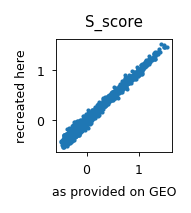

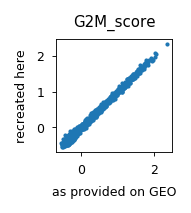

In [41]:
label = 'S_score'
x = adata[cell_mask].obs[label]
y = cdata.obs[label]

plt.figure(figsize=(1,1))
plt.scatter(x,y,s=1)
plt.xlabel('as provided on GEO')
plt.ylabel('recreated here')
plt.title(label)
plt.show()


label = 'G2M_score'
x = adata[cell_mask].obs[label]
y = cdata.obs[label]

plt.figure(figsize=(1,1))
plt.scatter(x,y,s=1)
plt.xlabel('as provided on GEO')
plt.ylabel('recreated here')
plt.title(label)
plt.show()

In [48]:
mismatches = adata[cell_mask].obs['phase'].values != cdata.obs['phase'].values
print("%d cells out of %d receive a different phase label"%(mismatches.sum(),len(mismatches)))

50 cells out of 2349 receive a different phase label
